<a href="https://colab.research.google.com/github/mericamp97/-greenhouse-job-description-scraper-chrome-extension/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Whales

## Data Loading

In [ ]:
pip install seaborn

In [ ]:
pip install hdbscan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039274 sha256=ff86665f8ce93bb8d53b06b5aa32760b61eacefcbaefbc67a146e5e8815bbd2d
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9


In [ ]:
!pip install transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

import numpy as np

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

In [ ]:
file_path_profile = '/content/drive/My Drive/BT5153_Kaggle/profile.csv'
profile = pd.read_csv(file_path_profile)
file_path_trx = '/content/drive/My Drive/BT5153_Kaggle/trx_data.csv'
trx = pd.read_csv(file_path_trx)
file_path_trx = '/content/drive/My Drive/BT5153_Kaggle/train_label.csv'
train_label = pd.read_csv(file_path_trx)

In [ ]:
profile[:5]

,user_id,mobile_brand_name,mobile_marketing_name,age_in_year,gender_name,marital_status,education_background,income_level,occupation
0,53058,POCO,m3 pro 5g,45.0,Male,NaN,NaN,NaN,NaN
1,74136,Nokia,3,52.0,Male,NaN,NaN,NaN,NaN
2,159548,POCO,m3 pro 5g,52.0,Female,NaN,NaN,NaN,NaN
3,156814,OnePlus,8,62.0,Male,NaN,NaN,NaN,NaN
4,122581,LG,g7 thinq,48.0,Female,NaN,NaN,NaN,NaN


In [ ]:
trx[:5]

,transaction_time,user_id,transaction_type,asset_type,gtv
0,2022-04-01 00:00:01.382,59345,SELL,crypto,571.296429
1,2022-04-01 00:00:02.218,76970,BUY,crypto,26.780357
2,2022-04-01 00:00:04.892,81533,BUY,crypto,8.916071
3,2022-04-01 00:00:05.002,2767,SELL,crypto,685.591071
4,2022-04-01 00:00:05.769,34438,SELL,crypto,81.142857


In [ ]:
train_label[:5]

,user_id,tgt
0,92167,0
1,9930,0
2,176146,0
3,54961,0
4,49665,1


In [ ]:
profile = profile.merge(train_label, on='user_id', how='left')
profile[:5]

,user_id,mobile_brand_name,mobile_marketing_name,age_in_year,gender_name,marital_status,education_background,income_level,occupation,tgt
0,53058,POCO,m3 pro 5g,45.0,Male,NaN,NaN,NaN,NaN,1.0
1,74136,Nokia,3,52.0,Male,NaN,NaN,NaN,NaN,1.0
2,159548,POCO,m3 pro 5g,52.0,Female,NaN,NaN,NaN,NaN,0.0
3,156814,OnePlus,8,62.0,Male,NaN,NaN,NaN,NaN,1.0
4,122581,LG,g7 thinq,48.0,Female,NaN,NaN,NaN,NaN,0.0


# Feature Engineering

In [ ]:
trx['asset_type'].unique()

array(['crypto', 'gold', 'fx', 'gss', 'stock_index', 'idss', 'mfund'],
      dtype=object)

In [ ]:
import pandas as pd

# Assuming 'trx' is already loaded

# Convert transaction_time to datetime, if not already done
trx['transaction_time'] = pd.to_datetime(trx['transaction_time'])

# Pre-calculate flags for each transaction type and asset type
trx['sell_flag'] = (trx['transaction_type'] == 'SELL').astype(int)
trx['buy_flag'] = (trx['transaction_type'] == 'BUY').astype(int)

# For asset types, you can use get_dummies for a one-hot encoding approach
asset_type_dummies = pd.get_dummies(trx['asset_type'])
trx = pd.concat([trx, asset_type_dummies], axis=1)

# Now group by 'user_id' and sum up the flags and dummies
agg_dict = {
    'sell_flag': 'sum',
    'buy_flag': 'sum',
    'crypto': 'sum',
    'gold': 'sum',
    'fx': 'sum',
    'gss': 'sum',
    'stock_index': 'sum',
    'idss': 'sum',
    'mfund': 'sum'
}

# Adding total transactions as count of rows
agg_dict['user_id'] = 'count'

trx_counts = trx.groupby('user_id').agg(agg_dict).rename(columns={'user_id': 'total_transactions'})

# Let's check the first few rows of the optimized trx_counts
print(trx_counts.head())


         sell_flag  buy_flag  crypto  gold  fx  gss  stock_index  idss  mfund  \
user_id                                                                         
0                0         3       2     1   0    0            0     0      0   
1                0         9       8     1   0    0            0     0      0   
2                1         0       0     1   0    0            0     0      0   
3                0         6       4     0   1    1            0     0      0   
4                2         1       0     2   0    0            0     0      1   

         total_transactions  
user_id                      
0                         3  
1                         9  
2                         1  
3                         6  
4                         3  


In [ ]:
trx_counts['fx'].unique()

array([  0,   1,  43,   2,   4,  10,   9,  11,   8,   3,   7,  25,   6,
         5,  18,  13,  16,  22,  24,  19,  15,  12,  27,  17,  29,  20,
        28,  56,  21,  14,  39,  31,  49,  36,  58,  30, 103,  65,  32,
        37,  26,  52,  42,  38,  23,  76,  34, 115, 100,  41,  51],
      dtype=uint8)

In [ ]:

# Calculate GTV statistics
gtv_stats = trx.groupby('user_id')['gtv'].agg(['mean', 'median', 'max', 'min']).rename(columns={
    'mean': 'average_GTV',
    'median': 'median_GTV',
    'max': 'max_GTV',
    'min': 'min_GTV'
})

gtv_stats['max_minus_median_GTV'] = gtv_stats['max_GTV'] - gtv_stats['median_GTV']

# Display the first few rows of the modified GTV stats
print(gtv_stats.head())




         average_GTV  median_GTV      max_GTV     min_GTV  \
user_id                                                     
0          14.481548   16.669643    17.848214    8.926786   
1         270.889286   89.285714  1679.078571   89.282143   
2         162.785714  162.785714   162.785714  162.785714   
3         564.834226  535.711607   714.282143  442.687500   
4          19.985119   16.666071    26.750000   16.539286   

         max_minus_median_GTV  
user_id                        
0                    1.178571  
1                 1589.792857  
2                    0.000000  
3                  178.570536  
4                   10.083929  


In [ ]:
# Calculate average time between transactions in minutes
trx.sort_values(by=['user_id', 'transaction_time'], inplace=True)
trx['time_diff'] = trx.groupby('user_id')['transaction_time'].diff().dt.total_seconds() / 60
avg_time_diff = trx.groupby('user_id')['time_diff'].mean().to_frame('avg_time_between_transactions')

print(avg_time_diff[:5])

print(avg_time_diff['avg_time_between_transactions'].max())

         avg_time_between_transactions
user_id                               
0                            25.095825
1                          8375.102619
2                                  NaN
3                          8358.912597
4                          2659.806083
86359.67031666666


In [ ]:
# Calculate daily GTV percentage
trx['date'] = trx['transaction_time'].dt.date
daily_gtv = trx.groupby(['date', 'user_id'])['gtv'].sum().reset_index()
daily_total_gtv = trx.groupby('date')['gtv'].sum().reset_index(name='total_gtv')
daily_gtv = pd.merge(daily_gtv, daily_total_gtv, on='date')
daily_gtv['daily_gtv_percentage'] = daily_gtv['gtv'] / daily_gtv['total_gtv'] * 100
avg_daily_gtv_percentage = daily_gtv.groupby('user_id')['daily_gtv_percentage'].mean().to_frame('avg_daily_gtv_percentage')

print(avg_daily_gtv_percentage[:5])
print(avg_daily_gtv_percentage['avg_daily_gtv_percentage'].max())

         avg_daily_gtv_percentage
user_id                          
0                        0.000153
1                        0.003412
2                        0.000867
3                        0.003553
4                        0.000119
5.402543659339173


In [ ]:
#CALCULATE AND MERGE SUMS

# Group by user_id and asset_type, then sum the GTV
gtv_by_asset_user = trx.groupby(['user_id', 'asset_type'])['gtv'].sum()

# Unstack to create a DataFrame where each asset type is a column, and fill missing values with 0
gtv_by_asset_user = gtv_by_asset_user.unstack(fill_value=0)

# Rename the columns using a dictionary comprehension
# The keys of the dictionary are the current column names (i.e., asset types)
# and the values are the new column names in the format '{assetType}_sum'
gtv_by_asset_user.columns = [f'{col}_sum' for col in gtv_by_asset_user.columns]

# You can now merge this with your existing DataFrame 'profile' on 'user_id'
profile = profile.merge(gtv_by_asset_user, on='user_id', how='left', suffixes=('', '_total_gtv'))



In [ ]:
# Combine all the metrics
metrics = [trx_counts, gtv_stats, avg_time_diff, avg_daily_gtv_percentage]
for metric in metrics:
    profile = profile.merge(metric, on='user_id', how='left')

# Fill NaN values with 0 or an appropriate value for columns that may not have data for all users
profile.fillna({
    'total_transactions': 0, 'sell_transactions': 0, 'buy_transactions': 0, 'crypto_transactions': 0,
    'gold_transactions': 0, 'fx_transactions': 0, 'gss_transactions': 0, 'stock_index_transactions': 0,
    'idss_transactions': 0, 'mfund_transactions': 0,
    'average_GTV': -99,
    'median_GTV': -99,
    'max_GTV': -99,
    'min_GTV': -99,
    #'avg_time_between_transactions': 1000000, #The maximum time between transactions is 86k minutes. People that only did one transaction is not likely to be a whale, so I put the NaNs as very very high
    'avg_daily_gtv_percentage': -99
}, inplace=True)


# Calculate the median of 'avg_time_between_transactions' excluding NaN values
median_value = profile['avg_time_between_transactions'].median()

# Fill NaN values in 'avg_time_between_transactions' with the calculated median
profile['avg_time_between_transactions'] = profile['avg_time_between_transactions'].fillna(median_value)


# Display the enriched profile DataFrame
print(profile.head())

   user_id mobile_brand_name mobile_marketing_name  age_in_year gender_name  \
0    53058              POCO             m3 pro 5g         45.0        Male   
1    74136             Nokia                     3         52.0        Male   
2   159548              POCO             m3 pro 5g         52.0      Female   
3   156814           OnePlus                     8         62.0        Male   
4   122581                LG              g7 thinq         48.0      Female   

  marital_status education_background income_level occupation  tgt  ...  idss  \
0            NaN                  NaN          NaN        NaN  1.0  ...     0   
1            NaN                  NaN          NaN        NaN  1.0  ...     0   
2            NaN                  NaN          NaN        NaN  0.0  ...     0   
3            NaN                  NaN          NaN        NaN  1.0  ...     0   
4            NaN                  NaN          NaN        NaN  0.0  ...     0   

   mfund  total_transactions  average_

In [ ]:
print(profile.columns)


Index(['user_id', 'mobile_brand_name', 'mobile_marketing_name', 'age_in_year',
       'gender_name', 'marital_status', 'education_background', 'income_level',
       'occupation', 'tgt', 'crypto_sum', 'fx_sum', 'gold_sum', 'gss_sum',
       'idss_sum', 'mfund_sum', 'stock_index_sum', 'sell_flag', 'buy_flag',
       'crypto', 'gold', 'fx', 'gss', 'stock_index', 'idss', 'mfund',
       'total_transactions', 'average_GTV', 'median_GTV', 'max_GTV', 'min_GTV',
       'max_minus_median_GTV', 'avg_time_between_transactions',
       'avg_daily_gtv_percentage'],
      dtype='object')


In [ ]:

# Mapping of old column names to new column names
column_rename_mapping = {
    'sell_flag': 'sell_count',
    'buy_flag': 'buy_count',
    'crypto': 'crypto_count',
    'gold': 'gold_count',
    'fx': 'fx_count',
    'gss': 'gss_count',
    'stock_index': 'stock_index_count',
    'idss': 'idss_count',
    'mfund': 'mfund_count',
}

# Rename the columns
profile.rename(columns=column_rename_mapping, inplace=True)

# Display the first few rows to verify the changes
print(profile.head())


   user_id mobile_brand_name mobile_marketing_name  age_in_year gender_name  \
0    53058              POCO             m3 pro 5g         45.0        Male   
1    74136             Nokia                     3         52.0        Male   
2   159548              POCO             m3 pro 5g         52.0      Female   
3   156814           OnePlus                     8         62.0        Male   
4   122581                LG              g7 thinq         48.0      Female   

  marital_status education_background income_level occupation  tgt  ...  \
0            NaN                  NaN          NaN        NaN  1.0  ...   
1            NaN                  NaN          NaN        NaN  1.0  ...   
2            NaN                  NaN          NaN        NaN  0.0  ...   
3            NaN                  NaN          NaN        NaN  1.0  ...   
4            NaN                  NaN          NaN        NaN  0.0  ...   

   idss_count  mfund_count  total_transactions  average_GTV   median_GTV  

In [ ]:
profile['fx_count'].unique()

array([  0,   2,   8,   4,   3,   7,   5,   1,   6,   9,  36,  37,  10,
        18,  29,  12,  27,  11,  17,  14,  42,  15,  13,  16,  20,  26,
        22,  52,  49,  19,  24,  30,  43,  76,  23,  32,  34,  38,  25,
        31,  21, 103,  56,  58,  28,  39, 100,  65, 115,  41,  51],
      dtype=uint8)

### Visualize if the created feature have any relation with the target column

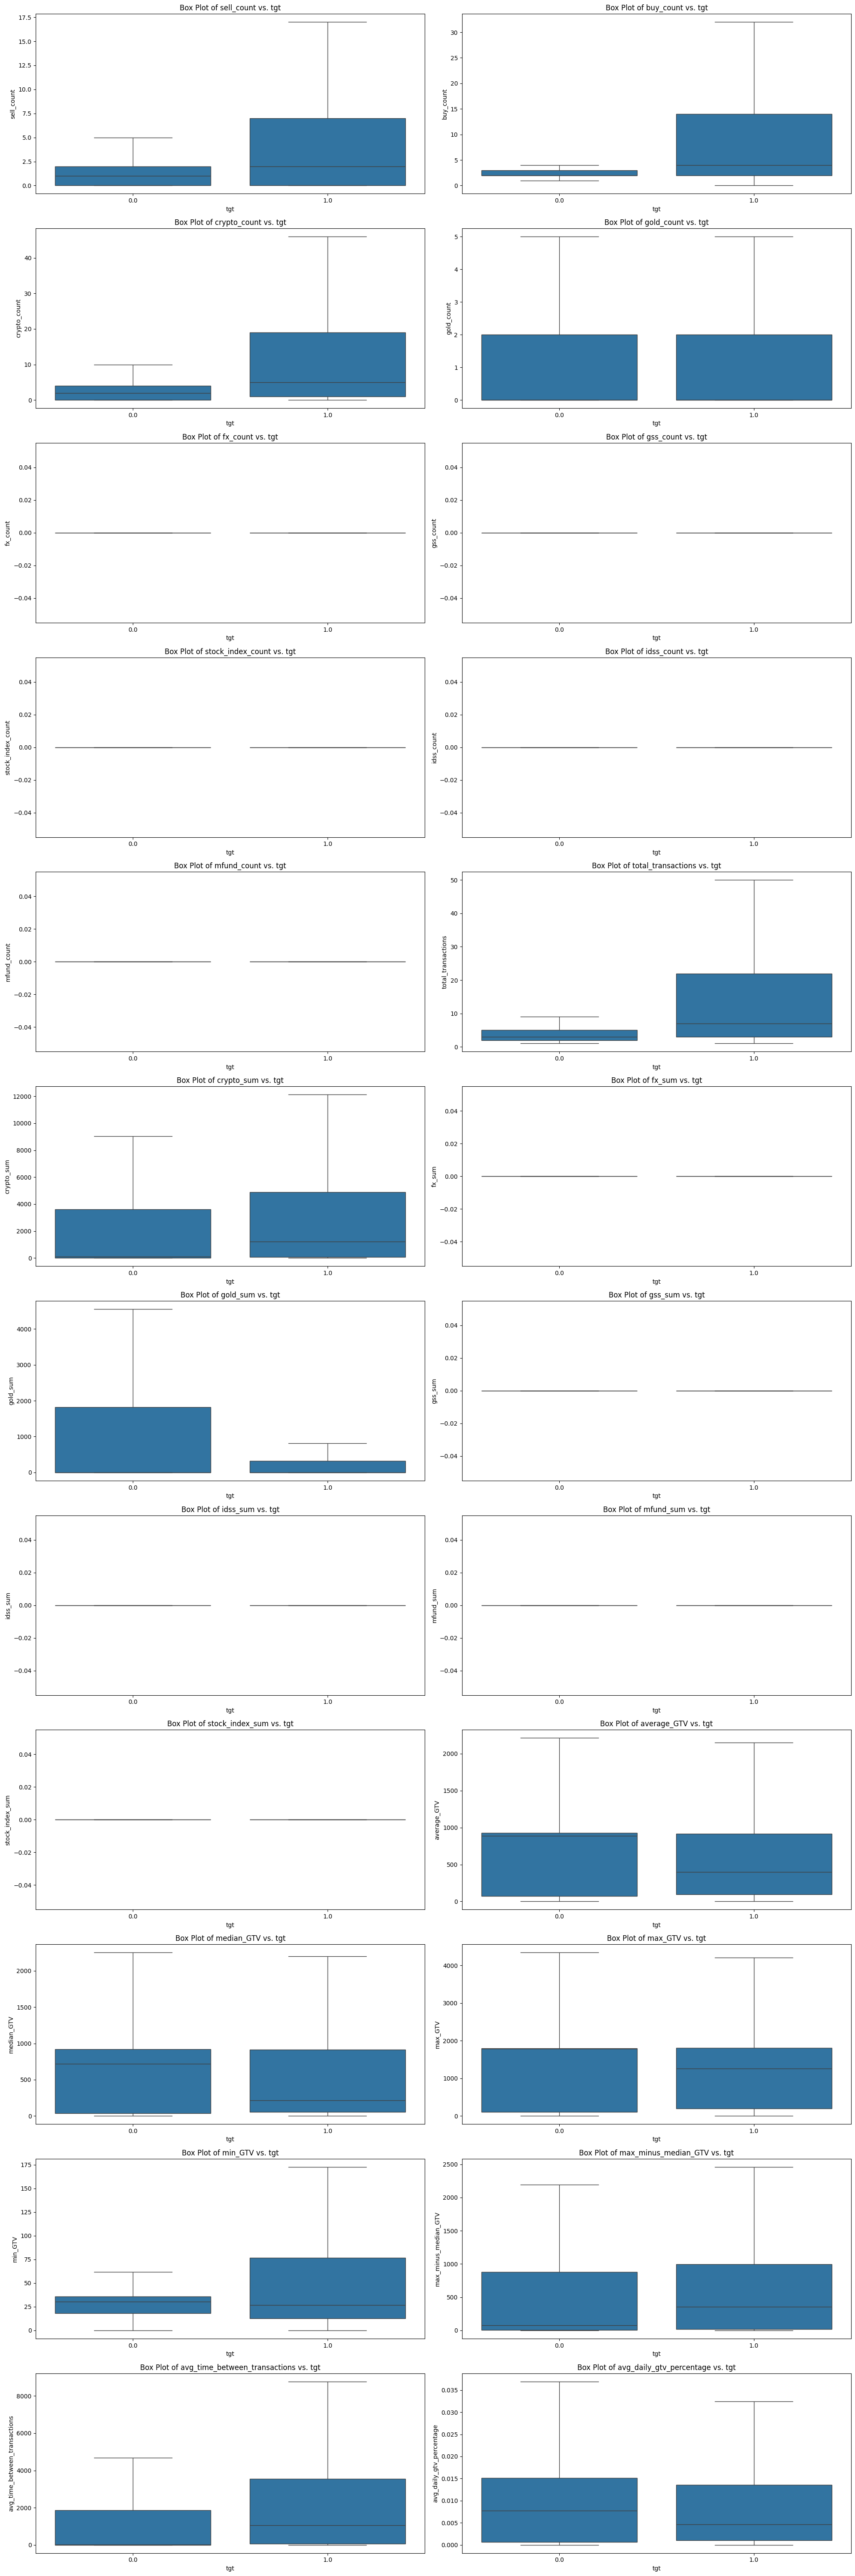

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt


# List of columns to compare with 'tgt'
columns = [
    'sell_count', 'buy_count', 'crypto_count', 'gold_count', 'fx_count',
    'gss_count', 'stock_index_count', 'idss_count', 'mfund_count', 'total_transactions', 'crypto_sum', 'fx_sum', 'gold_sum', 'gss_sum',
       'idss_sum', 'mfund_sum', 'stock_index_sum',
    'average_GTV', 'median_GTV', 'max_GTV', 'min_GTV', 'max_minus_median_GTV',
    'avg_time_between_transactions', 'avg_daily_gtv_percentage'
]

# Calculate how many rows we will need
n_rows = len(columns) // 2 + len(columns) % 2

# Set up the matplotlib figure with a larger size
plt.figure(figsize=(20, 5 * n_rows))

# Loop through each column and create a subplot with a box plot
for i, column in enumerate(columns):
    plt.subplot(n_rows, 2, i + 1)  # Create a new subplot for each boxplot
    sns.boxplot(x='tgt', y=column, data=profile, showfliers=False, whis=1.5)  # No outliers, whiskers at 1.5 * IQR

    # If your data spans several orders of magnitude, uncomment the following line:
    # plt.yscale('log')

    plt.title(f'Box Plot of {column} vs. tgt')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
corr_variables = ['tgt',
    'sell_count', 'buy_count', 'crypto_count', 'gold_count', 'fx_count',
    'gss_count', 'stock_index_count', 'idss_count', 'mfund_count', 'total_transactions', 'crypto_sum', 'fx_sum', 'gold_sum', 'gss_sum',
       'idss_sum', 'mfund_sum', 'stock_index_sum',
    'average_GTV', 'median_GTV', 'max_GTV', 'min_GTV', 'max_minus_median_GTV',
    'avg_time_between_transactions', 'avg_daily_gtv_percentage'
]

profile[corr_variables].corr().style.background_gradient(cmap='bwr_r', vmin=-1, vmax=1)

,tgt,sell_count,buy_count,crypto_count,gold_count,fx_count,gss_count,stock_index_count,idss_count,mfund_count,total_transactions,crypto_sum,fx_sum,gold_sum,gss_sum,idss_sum,mfund_sum,stock_index_sum,average_GTV,median_GTV,max_GTV,min_GTV,max_minus_median_GTV,avg_time_between_transactions,avg_daily_gtv_percentage
tgt,1.000000,0.106930,0.117661,0.112048,0.043732,0.129999,0.099550,0.081873,0.012891,0.051186,0.118140,0.175559,0.060820,0.016850,0.057480,0.010251,0.015189,0.038346,0.017983,0.003990,0.046678,0.014167,0.057367,0.026288,0.009681
sell_count,0.106930,1.000000,0.837345,0.923086,0.103660,0.138876,0.132013,0.062127,0.016026,0.043907,0.925594,0.274802,0.037966,0.048672,0.046318,0.005841,0.001023,0.014969,-0.009839,-0.015895,0.015938,-0.006756,0.029854,-0.024544,0.011759
buy_count,0.117661,0.837345,1.000000,0.980643,0.068598,0.130931,0.120763,0.100199,0.014370,0.071165,0.981968,0.252587,0.041704,0.000510,0.045907,0.005872,0.006005,0.025166,-0.011404,-0.016896,0.019103,-0.006723,0.034530,-0.028736,0.005800
crypto_count,0.112048,0.923086,0.980643,1.000000,0.043803,0.108073,0.097475,0.071244,0.000355,0.038204,0.998216,0.269813,0.028371,-0.005547,0.031425,-0.000855,0.000443,0.015438,-0.011641,-0.016825,0.015625,-0.006727,0.029990,-0.029126,0.006614
gold_count,0.043732,0.103660,0.068598,0.043803,1.000000,0.045397,0.019804,0.058164,-0.003776,0.073049,0.083345,-0.027560,0.005944,0.609707,0.002233,-0.004965,-0.000845,0.008994,-0.001419,-0.010193,0.014481,-0.009824,0.024655,0.010384,0.005581
fx_count,0.129999,0.138876,0.130931,0.108073,0.045397,1.000000,0.581924,0.236708,0.000735,0.045980,0.138682,0.104943,0.406925,0.009579,0.356621,-0.000771,0.002381,0.097539,-0.001176,-0.010673,0.029768,-0.004893,0.044704,-0.012018,0.022073
gss_count,0.099550,0.132013,0.120763,0.097475,0.019804,0.581924,1.000000,0.176646,0.000845,0.042114,0.129269,0.067530,0.308328,0.005765,0.487853,-0.000078,0.001654,0.063169,0.001161,-0.005054,0.023695,-0.002897,0.033584,-0.009185,0.021288
stock_index_count,0.081873,0.062127,0.100199,0.071244,0.058164,0.236708,0.176646,1.000000,0.000549,0.053299,0.090862,0.034713,0.112663,0.007651,0.093773,0.002479,0.002716,0.403070,0.002604,-0.001568,0.017915,0.001668,0.024081,0.003941,0.008655
idss_count,0.012891,0.016026,0.014370,0.000355,-0.003776,0.000735,0.000845,0.000549,1.000000,0.000360,0.015492,0.000272,0.000726,-0.001670,0.001112,0.467425,-0.000113,0.000214,0.010904,0.009358,0.020845,0.005053,0.021518,0.001442,0.019306
mfund_count,0.051186,0.043907,0.071165,0.038204,0.073049,0.045980,0.042114,0.053299,0.000360,1.000000,0.064459,0.007211,0.011697,-0.001068,0.014714,-0.000812,0.183702,0.012791,0.004433,-0.000337,0.059504,0.003482,0.077153,0.019058,0.008189


In [ ]:
columns = ['mobile_brand_name', 'mobile_marketing_name', 'age_in_year',
       'gender_name', 'marital_status', 'education_background', 'income_level',
       'occupation', 'tgt']

for c in columns:
    print(c)
    print(profile[c].unique())
    nulls = profile[c].isna().sum()
    null_data = profile[c].isna()
    null_tgt = profile[null_data]['tgt'].value_counts()
    print(f'The number of NULL in {c} is {nulls}')
    print(null_tgt)
    print('\n')

mobile_brand_name
['POCO' 'Nokia' 'OnePlus' 'LG' 'Sony' 'Advan' 'Spice' 'itel' 'Lenovo'
 'Luna' 'BlackBerry' 'Wiko' 'InFocus' 'Sharp' 'Tecno' 'Motorola' 'Coolpad'
 'Mito' 'Honor' 'Evercoss' 'Meizu' 'Fujitsu' 'China Mobile' 'Andromax'
 'Au' 'ZTE' 'Acer' 'Alcatel' 'Kyocera' 'YES' 'Asus' 'OPPO' 'Vivo' 'Huawei'
 'Realme' 'Xiaomi' 'Infinix' 'Samsung' 'Vernee' 'DoCoMo' 'Haier' 'HTC'
 'Himax' 'Lava' 'Polytron' 'LYF' 'Amazon' 'TCL' 'Smartfren' 'Teclast'
 'SoftBank' 'Benco' 'Micromax' 'BQ' 'Meitu']
The number of NULL in mobile_brand_name is 0
Series([], Name: tgt, dtype: int64)


mobile_marketing_name
['m3 pro 5g' '3' '8' 'g7 thinq' 'xperia xz3' 'm4 pro' 'x3 gt' 'nasa plus'
 'xperia xz2 premium' 'g5' 'dream uno' 'xperia xa1' 'vision 1 pro'
 'xperia xz2' 's5' '8t' 'v lite' '7 pro' 'aurora' '5' 'keyone' 'view4'
 'a26' '6' 'v30' 'xperia xz1' 'turbo 5' 'aquos sense4 plus' 'stylo 2'
 'pop 5 lte' 'spark go 2020' 'nasa' 'xperia 5' 'vision 1' 'harry 2'
 'xperia z5' 'g9' 'edge 20 pro' 'k5 pro' 's50 prim

In [ ]:
profile.shape

(188427, 34)

In [ ]:
# Checking for rows where all specified columns are NaN
all_nulls = profile[['marital_status', 'education_background', 'income_level', 'occupation']].isna().all(axis=1).sum()

# Checking for rows where any of the specified columns are NaN
any_nulls = profile[['marital_status', 'education_background', 'income_level', 'occupation']].isna().any(axis=1)

# Count the 'tgt' values where any of these columns are NaN
tgt_counts_when_nulls = profile[any_nulls]['tgt'].value_counts()

print(all_nulls)

print(tgt_counts_when_nulls)

104228
0.0    68714
1.0    14759
Name: tgt, dtype: int64


In [ ]:
print(profile['tgt'].value_counts())

0.0    109316
1.0     41425
Name: tgt, dtype: int64


In [ ]:
words = []
for name in profile['mobile_marketing_name']:
    # Extract words that are 2 characters or longer and not numbers
    words.extend(re.findall(r'\b[a-zA-Z]{2,}\b', name))

# Count the occurrences of each word
word_counts = Counter(words)

# Filter out single character words and sort by the most common
common_words = {word: count for word, count in word_counts.items() if len(word) > 1}

common_words_sorted = dict(sorted(common_words.items(), key=lambda item: item[1], reverse=True))

# Display the most common words
common_words_sorted

{'galaxy': 42278,
 'redmi': 31126,
 'pro': 22107,
 'note': 20145,
 'poco': 9079,
 'hot': 4428,
 'nfc': 3259,
 'play': 2039,
 'zenfone': 1929,
 'max': 1580,
 'mi': 1553,
 'lite': 1478,
 'prime': 1461,
 'narzo': 1184,
 'xperia': 1165,
 'youth': 1030,
 'ultra': 972,
 'thinq': 946,
 'xt': 899,
 'smart': 743,
 'gt': 736,
 'edge': 664,
 'plus': 640,
 'core': 597,
 'honor': 593,
 'nacho': 480,
 'fe': 453,
 'nasa': 356,
 'phone': 342,
 'rog': 341,
 'premium': 339,
 'tab': 328,
 'edition': 322,
 'december': 317,
 'se': 246,
 'nova': 233,
 'master': 209,
 'mate': 188,
 'duos': 169,
 'spark': 165,
 'zero': 152,
 'reno': 147,
 'vision': 122,
 'ii': 117,
 'aquos': 116,
 'ace': 104,
 'neo': 94,
 'compact': 92,
 'live': 92,
 'lte': 88,
 'india': 87,
 'black': 76,
 'shark': 76,
 'go': 68,
 'star': 66,
 'nxt': 65,
 'xz': 56,
 'qualcomm': 56,
 'fan': 54,
 'find': 52,
 'oppo': 50,
 'xzs': 46,
 'vibe': 45,
 'selfie': 38,
 'pova': 37,
 'zoom': 37,
 'enjoy': 37,
 'dream': 34,
 'uno': 34,
 'nex': 34,
 'auror

In [ ]:
# ALTERNATIVE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import hdbscan
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    # Tokenize the texts
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Perform mean pooling to get sentence embeddings
    embeddings = model_output.last_hidden_state.mean(dim=1)
    return embeddings

# Find unique marketing names and their indices
unique_texts = profile['mobile_marketing_name'].unique().tolist()

# Get embeddings for the unique values only
unique_embeddings = get_bert_embeddings(unique_texts)

# Normalize the embeddings
unique_embeddings_np = unique_embeddings.numpy()
unique_embeddings_norm = normalize(unique_embeddings_np)

# Fit HDBSCAN on the unique normalized embeddings
hdbscan_cluster = hdbscan.HDBSCAN(
    min_cluster_size = 10,
    metric='euclidean'
)
hdbscan_cluster.fit(unique_embeddings_norm)

# Create a dictionary mapping unique marketing names to cluster labels
name_to_cluster = dict(zip(unique_texts, hdbscan_cluster.labels_))

# Map each row in 'profile' to its cluster label using the dictionary
profile['marketing_cluster'] = profile['mobile_marketing_name'].map(name_to_cluster)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
profile[['marketing_cluster','user_id']].groupby('marketing_cluster').count()

,user_id
marketing_cluster,
-1,74183
0,41869
1,1160
2,546
3,27383
4,25505
5,17781


In [ ]:
profile['contains_honor'] = profile['mobile_marketing_name'].str.contains('honor', case=False, na=False).astype(int)

In [ ]:
profile.columns

Index(['user_id', 'mobile_brand_name', 'mobile_marketing_name', 'age_in_year',
       'gender_name', 'marital_status', 'education_background', 'income_level',
       'occupation', 'tgt', 'crypto_sum', 'fx_sum', 'gold_sum', 'gss_sum',
       'idss_sum', 'mfund_sum', 'stock_index_sum', 'sell_count', 'buy_count',
       'crypto_count', 'gold_count', 'fx_count', 'gss_count',
       'stock_index_count', 'idss_count', 'mfund_count', 'total_transactions',
       'average_GTV', 'median_GTV', 'max_GTV', 'min_GTV',
       'max_minus_median_GTV', 'avg_time_between_transactions',
       'avg_daily_gtv_percentage', 'marketing_cluster', 'contains_honor'],
      dtype='object')

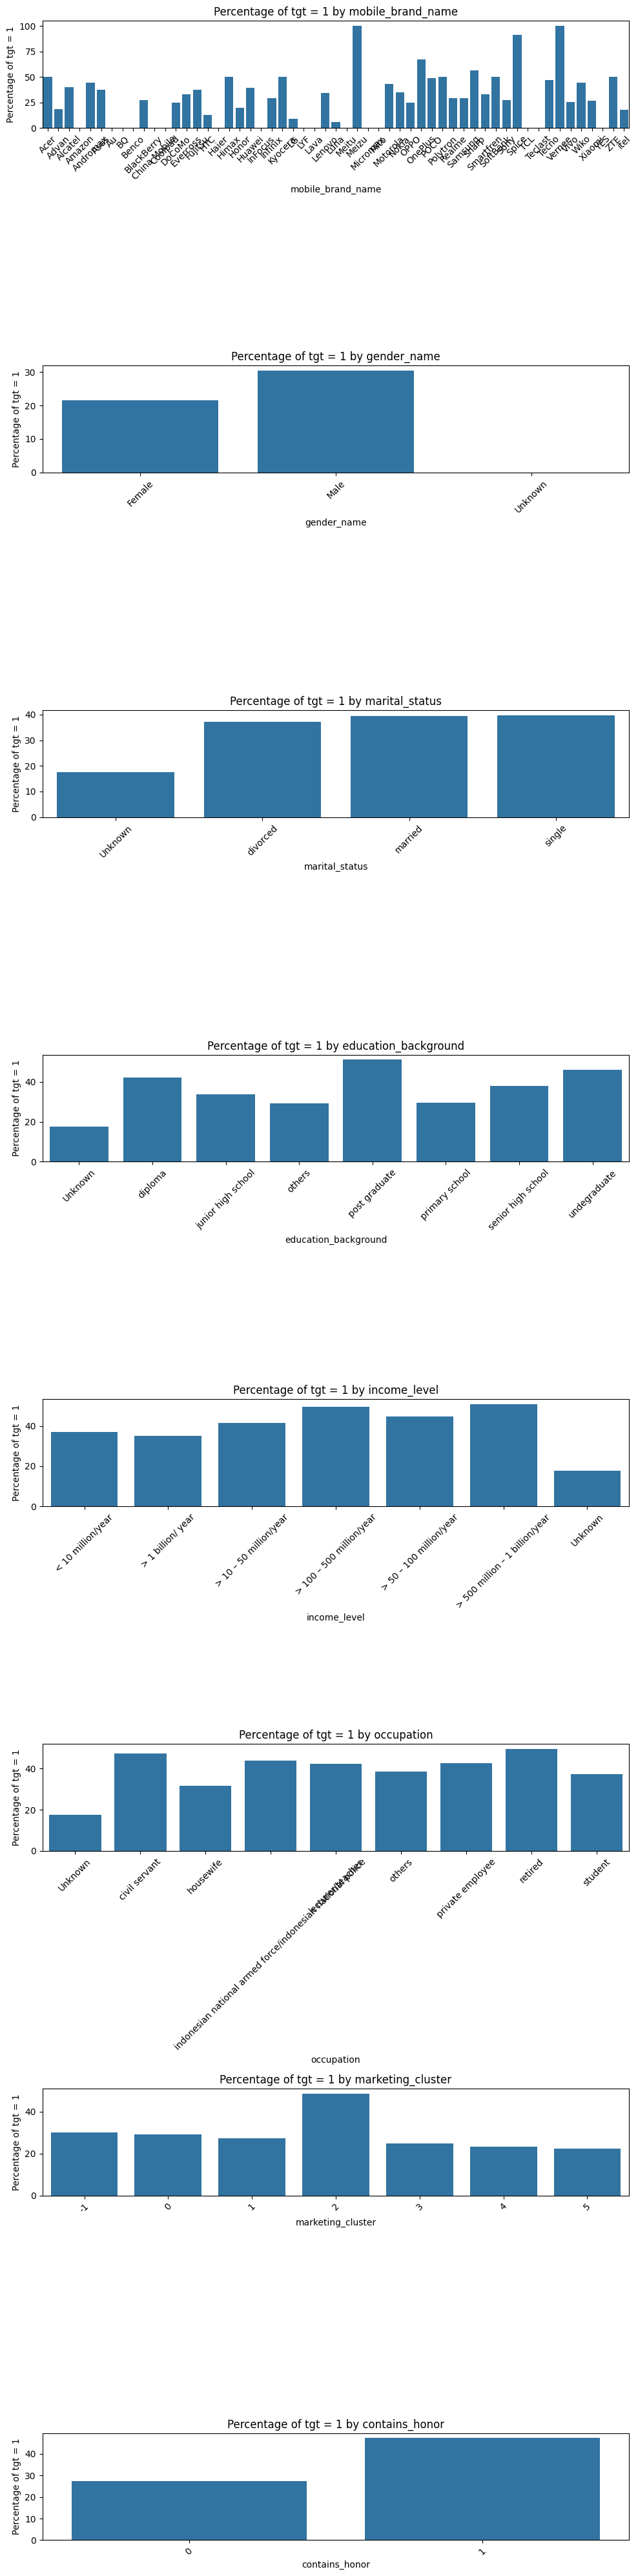

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical columns for which to plot bar charts
categorical_columns = [
    'mobile_brand_name',
    'gender_name', 'marital_status', 'education_background',
    'income_level', 'occupation', 'marketing_cluster', 'contains_honor'
]

filled_profile = profile.copy()
for col in categorical_columns:
    filled_profile[col] = filled_profile[col].fillna('Unknown')

# Continue with the same plotting code as before, using 'filled_profile' instead of 'profile'
fig, axs = plt.subplots(len(categorical_columns), 1, figsize=(10, 5 * len(categorical_columns)))

for i, col in enumerate(categorical_columns):
    # Calculate the percentage of 'tgt' = 1 for each category, including the 'Unknown' category
    percentage_tgt_1 = filled_profile.groupby(col)['tgt'].mean() * 100

    # Plot
    sns.barplot(x=percentage_tgt_1.index, y=percentage_tgt_1.values, ax=axs[i])
    axs[i].set_ylabel('Percentage of tgt = 1')
    axs[i].set_title(f'Percentage of tgt = 1 by {col}')
    for item in axs[i].get_xticklabels():
        item.set_rotation(45)

plt.tight_layout()
plt.show()


In [ ]:
for i in profile['marketing_cluster'].unique():
  print(f'cluster number {i}')
  print(profile[profile['marketing_cluster']==i]['mobile_marketing_name'].unique())

cluster number -1
['m3 pro 5g' '3' '8' 'g7 thinq' 'm4 pro' 'x3 gt' 'nasa plus' 'g5'
 'dream uno' 'vision 1 pro' 's5' '8t' 'v lite' '7 pro' 'aurora' '5'
 'keyone' 'view4' '6' 'turbo 5' 'aquos sense4 plus' 'stylo 2' 'pop 5 lte'
 'spark go 2020' 'nasa' 'vision 1' 'harry 2' 'g9' 'edge 20 pro' 'k5 pro'
 's50 prime' 'f4 gt' 'sky 3' 'aquos v' 'a6600' 'v20' 'vibe k4 note'
 'g5 se' 'fantasy x' 'aquos zero 2' 'spark 7 pro' 'v40 5g' 'spark 7 go'
 'aquos zeta' 'winner t' 'vibe p1m' 'vibe p1' 'stylus 3' 'g2' 'g1 pro'
 'aquos r' 'm2' 'x power' 'arrows tab' 'vibe k5 plus' 'spark 6 go'
 'stylus 2 plus' 'xz premium' 'pova neo' 'xtream 1 plus'
 'xperia z2 so-03f for docomo' 'view4 lite' 'moto z play' '7t' 'k10' 'b'
 'k5 play' 'g5 elite' 'k5 note (2018)' 'p36 pro lte' 'v35 thinq' '5t'
 'k6 note' 'aquos serie' 'nubia red magic 5g' 'aquos r3' 'aquos r2'
 'moto e3 power' 'liquid jade z' 'view max' '1s (2020)' 'pova' 'v40 thinq'
 'aquos m1' 's16 pro（vision 2）' 'qua phone qz' 'altitude'
 'zenfone max pro m2' 

In [ ]:
profile['mobile_brand_name'].value_counts()

Samsung         42286
Xiaomi          42232
OPPO            34599
Vivo            32520
Realme          19239
Infinix          7405
Asus             2272
POCO             2015
Huawei           1492
Sony             1185
LG               1041
Advan             648
OnePlus           434
itel              219
Tecno             206
Lenovo            149
Sharp             114
Nokia             102
Luna               42
BlackBerry         35
Spice              34
ZTE                18
Honor              14
Wiko               12
HTC                11
Andromax           10
Fujitsu            10
Motorola            9
DoCoMo              9
Mito                6
Evercoss            6
Alcatel             6
Lava                5
Smartfren           5
YES                 5
Kyocera             3
Micromax            2
Coolpad             2
Meizu               2
Benco               2
Polytron            2
Acer                2
SoftBank            2
Himax               2
Haier               2
LYF       

# MODELS

### Model Preparation

In [ ]:
df = profile[profile['tgt'].notna()].copy()

In [ ]:
brand_names = [
    'Samsung', 'Xiaomi', 'OPPO', 'Vivo', 'Realme', 'Infinix', 'Asus', 'POCO',
    'Huawei', 'Sony', 'LG', 'Advan', 'OnePlus', 'itel', 'Tecno', 'Lenovo',
    'Sharp', 'Nokia'
]

# Label 'mobile_brand_name' as 'Other' if it is not in the provided list
df['mobile_brand_name'] = df['mobile_brand_name'].apply(lambda x: x if x in brand_names else 'Other')

In [ ]:
df['education_background'] = df['education_background'].fillna('others')

In [ ]:
## Ordinal variables ##

# Maps for the ordinal columns
education_mapping = {
    'others': 0,
    'primary school': 1,
    'junior high school': 2,
    'senior high school': 3,
    'diploma': 4,
    'undegraduate': 5,
    'post graduate': 6
}

income_mapping = {
    np.nan: 0,  # Handle NaN values
    '< 10 million/year': 1,
    '> 10 – 50 million/year': 2,
    '> 50 – 100 million/year': 3,
    '> 100 – 500 million/year': 4,
    '> 500 million – 1 billion/year': 5,
    '> 1 billion/ year': 6
}

# Apply the mapping to the columns
df['education_background'] = df['education_background'].map(education_mapping).fillna(0).astype(int)
df['income_level'] = df['income_level'].map(income_mapping).fillna(0).astype(int)

df[['education_background','income_level']].head()

,education_background,income_level
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [ ]:
df.groupby(['education_background', 'income_level']).size().reset_index(name='counts')

,education_background,income_level,counts
0,0,0,83471
1,0,1,2023
2,0,2,527
3,0,3,126
4,0,4,36
5,0,5,11
6,0,6,28
7,1,1,2607
8,1,2,605
9,1,3,92


In [ ]:
#Creating the baseline model with regularization allowed
#defining the target variable

X = df.drop(columns = ['tgt']) # <- drop the y column
y = df['tgt']


### Pre-processing Steps ###
numerical_columns = ['sell_count', 'buy_count', 'crypto_count',
       'gold_count', 'fx_count', 'gss_count', 'stock_index_count',
       'idss_count', 'mfund_count', 'total_transactions', 'average_GTV',
       'median_GTV', 'max_GTV', 'min_GTV', 'max_minus_median_GTV',
       'avg_time_between_transactions', 'avg_daily_gtv_percentage', 'age_in_year', 'contains_honor']  # numerical columns # I add honor here because I want to passthrough although it is technically a one-hot

onehot_columns = ['mobile_brand_name','gender_name','marital_status','occupation','marketing_cluster']  # categorical columns for onehot encoding

encoded_ordinal_columns = ['education_background','income_level']        # ordinal columns already encoded, hence we will pass through them

onehot = OneHotEncoder(categories = [
                            ['POCO', 'Nokia', 'OnePlus', 'LG', 'Sony', 'Advan', 'Other', 'Lenovo', 'itel',
 'Tecno', 'Sharp', 'Asus', 'OPPO', 'Vivo', 'Huawei', 'Realme', 'Xiaomi', 'Infinix','Samsung'], # mobile_brand_name
                            ['Male', 'Female'], # gender_name
                            ['married', 'single', 'divorced'], # marital_status
                            ['housewife', 'private employee', 'others', 'student', 'civil servant','retired', 'lecturer/teacher', 'indonesian national armed force/indonesian national police'], #occupation
                            [-1,0,1,2,3,4,5] #marekting_cluster
                         ],
                         handle_unknown = 'ignore',
                        )

encoder = ColumnTransformer([
   #(nickname, encoder to apply, columns to apply to)
    ('numerical', 'passthrough', numerical_columns),
    ('already_encoded_ordinal', 'passthrough', encoded_ordinal_columns),
    ('onehot', onehot, onehot_columns)
])


scaler = StandardScaler()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023, stratify = y)

In [ ]:
X_train.columns

Index(['user_id', 'mobile_brand_name', 'mobile_marketing_name', 'age_in_year',
       'gender_name', 'marital_status', 'education_background', 'income_level',
       'occupation', 'crypto_sum', 'fx_sum', 'gold_sum', 'gss_sum', 'idss_sum',
       'mfund_sum', 'stock_index_sum', 'sell_count', 'buy_count',
       'crypto_count', 'gold_count', 'fx_count', 'gss_count',
       'stock_index_count', 'idss_count', 'mfund_count', 'total_transactions',
       'average_GTV', 'median_GTV', 'max_GTV', 'min_GTV',
       'max_minus_median_GTV', 'avg_time_between_transactions',
       'avg_daily_gtv_percentage', 'marketing_cluster', 'contains_honor'],
      dtype='object')

# Majority Voting Model

### Feature selection

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

X_train_encoded = encoder.fit_transform(X_train)

# Assuming 'encoder' is a fitted ColumnTransformer
feature_names = encoder.get_feature_names_out()

# Fit the encoder and transform X
X_encoded = encoder.fit_transform(X)

# Scale the encoded features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Convert X_scaled to a DataFrame with the proper feature names
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# Add y to the DataFrame
X_scaled_df['tgt'] = y.values

# Compute the correlation matrix
corr_matrix = X_scaled_df.corr()

# Extract correlations with the target variable
correlations_with_target = corr_matrix['tgt'].drop('tgt', errors='ignore')

# Sort the correlations by their absolute values in descending order
sorted_correlations = correlations_with_target.abs().sort_values(ascending=False)

# Print the sorted correlations
print(sorted_correlations)

print(corr_matrix)




already_encoded_ordinal__education_background                                    0.252041
already_encoded_ordinal__income_level                                            0.227017
onehot__marital_status_single                                                    0.156017
onehot__occupation_private employee                                              0.152448
onehot__marital_status_married                                                   0.133163
numerical__fx_count                                                              0.129999
numerical__total_transactions                                                    0.118140
numerical__buy_count                                                             0.117661
numerical__crypto_count                                                          0.112048
numerical__sell_count                                                            0.106930
numerical__gss_count                                                             0.099550
onehot__oc

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, columns_to_drop):
        """
        transformer: the transformer object (e.g., ColumnTransformer) that has been fit to the data.
        columns_to_drop: list of column names to drop.
        """
        self.transformer = transformer
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        # Get the output feature names from the transformer
        self.feature_names = self.transformer.get_feature_names_out()

        # Find the indices of the columns to drop
        self.columns_to_drop_indices = [i for i, feature_name in enumerate(self.feature_names) if feature_name in self.columns_to_drop]

        return self

    def transform(self, X):
        # Drop the columns by indices
        return np.delete(X, self.columns_to_drop_indices, axis=1)



In [ ]:
columns_to_drop = [
    'onehot__occupation_indonesian national armed force/indonesian national police',
    'onehot__marekting_cluster_1',
'onehot__occupation_civil servant',
'onehot__marekting_cluster_2',
'onehot__occupation_retired',
'onehot__mobile_brand_name_Nokia',
'onehot__occupation_housewife',
'onehot__mobile_brand_name_Huawei',
'onehot__mobile_brand_name_Asus',
'onehot__mobile_brand_name_Sharp',
'onehot__mobile_brand_name_Tecno',
'onehot__mobile_brand_name_Lenovo',
'onehot__mobile_brand_name_Other',
'onehot__mobile_brand_name_Advan',
'onehot__mobile_brand_name_itel',
'onehot__gender_name_Male'
]



columns_to_drop =  [
'onehot__mobile_brand_name_OPPO',
'onehot__gender_name_Female',
'onehot__marketing_cluster_5',
'onehot__occupation_student',
'onehot__mobile_brand_name_Infinix',
'onehot__mobile_brand_name_Realme',
'onehot__mobile_brand_name_LG',
'onehot__occupation_civil servant',
'onehot__mobile_brand_name_Huawei',
'onehot__occupation_housewife',
'numerical__contains_honor',
'onehot__mobile_brand_name_Asus',
'onehot__marital_status_divorced',
'numerical__idss_count',
'onehot__marketing_cluster_2',
'onehot__marketing_cluster_1',
'onehot__occupation_lecturer/teacher',
'onehot__occupation_retired',
'onehot__mobile_brand_name_Tecno',
'onehot__mobile_brand_name_Sony',
'onehot__occupation_indonesian national armed force/indonesian national police',
'onehot__mobile_brand_name_Advan',
'onehot__mobile_brand_name_itel',
'onehot__mobile_brand_name_Other',
'onehot__mobile_brand_name_Lenovo',
'onehot__mobile_brand_name_Sharp',
'onehot__mobile_brand_name_Nokia']




columns_to_drop =  [ # This one has a ROC of 0.81724 in Kaggle
  'numerical__age_in_year',
'onehot__occupation_private employee',
'onehot__mobile_brand_name_Vivo',
'numerical__mfund_count',
'onehot__marketing_cluster_0',
'onehot__marital_status_married',
'onehot__marketing_cluster_-1',
'numerical__stock_index_count',
'onehot__marketing_cluster_4',
'onehot__occupation_others',
'onehot__gender_name_Male',
'onehot__mobile_brand_name_Xiaomi',
'onehot__marketing_cluster_3',
'onehot__mobile_brand_name_OPPO',
'onehot__gender_name_Female',
'onehot__marketing_cluster_5',
'onehot__occupation_student',
'onehot__mobile_brand_name_Infinix',
'onehot__mobile_brand_name_Realme',
'onehot__mobile_brand_name_LG',
'onehot__occupation_civil servant',
'onehot__mobile_brand_name_Huawei',
'onehot__occupation_housewife',
'numerical__contains_honor',
'onehot__mobile_brand_name_Asus',
'onehot__marital_status_divorced',
'numerical__idss_count',
'onehot__marketing_cluster_2',
'onehot__marketing_cluster_1',
'onehot__occupation_lecturer/teacher',
'onehot__occupation_retired',
'onehot__mobile_brand_name_Tecno',
'onehot__mobile_brand_name_Sony',
'onehot__occupation_indonesian national armed force/indonesian national police',
'onehot__mobile_brand_name_Advan',
'onehot__mobile_brand_name_itel',
'onehot__mobile_brand_name_Other',
'onehot__mobile_brand_name_Lenovo',
'onehot__mobile_brand_name_Sharp',
'onehot__mobile_brand_name_Nokia']




# This one is taking out the features with less than 0.09 corr with tgt but keeping important RF features
# Top Random Forest Features
#numerical__avg_time_between_transactions                                         0.097049
#numerical__sell_count                                                            0.071364
#numerical__max_minus_median_GTV                                                  0.060322
#numerical__max_GTV                                                               0.052659
#already_encoded_ordinal__education_background                                    0.047979
#numerical__crypto_count                                                          0.046799
#numerical__median_GTV                                                            0.046338
#numerical__min_GTV                                                               0.044077
#numerical__average_GTV                                                           0.038468
#numerical__avg_daily_gtv_percentage                                              0.032718

columns_to_drop =  [
'numerical__stock_index_count',
'onehot__occupation_student',
#'numerical__max_minus_median_GTV', #This feature is important in the random forest
'numerical__mfund_count',
'onehot__mobile_brand_name_POCO',
'onehot__occupation_civil servant',
'onehot__marketing_cluster_-1',
#'numerical__max_GTV',
'numerical__gold_count',
'onehot__mobile_brand_name_OnePlus',
'onehot__marketing_cluster_4',
'onehot__marketing_cluster_5',
'onehot__mobile_brand_name_LG',
'numerical__age_in_year',
'onehot__occupation_lecturer/teacher',
'onehot__mobile_brand_name_OPPO',
#'numerical__avg_time_between_transactions', #This feature is important in the random forest
'onehot__marketing_cluster_3',
'onehot__marketing_cluster_2',
'numerical__contains_honor',
'onehot__mobile_brand_name_Huawei',
'onehot__mobile_brand_name_Asus',
'onehot__mobile_brand_name_Vivo',
'onehot__occupation_indonesian national armed force/indonesian national police',
'onehot__mobile_brand_name_Samsung',
'onehot__marketing_cluster_0',
'onehot__marital_status_divorced',
'onehot__occupation_retired',
'onehot__occupation_housewife',
#'numerical__average_GTV',
'onehot__mobile_brand_name_Sharp',
'onehot__mobile_brand_name_Tecno',
#'numerical__min_GTV',
'numerical__idss_count',
'onehot__mobile_brand_name_Realme',
'onehot__mobile_brand_name_Advan',
'onehot__mobile_brand_name_Xiaomi',
#'numerical__avg_daily_gtv_percentage',
'onehot__mobile_brand_name_Infinix',
'onehot__mobile_brand_name_itel',
'onehot__mobile_brand_name_Other',
'onehot__mobile_brand_name_Lenovo',
#'numerical__median_GTV',
'onehot__mobile_brand_name_Nokia',
'onehot__marketing_cluster_1',
'onehot__mobile_brand_name_Sony',
'onehot__gender_name_Male'] # I take out Male because the information is already encoded in Female





columns_to_drop =  [ # This one has a ROC of 0.81767 in Kaggle --> This one is the one that works best for now.
    'numerical__fx_count',
'onehot__mobile_brand_name_POCO',
'onehot__marital_status_single',
'onehot__mobile_brand_name_OnePlus',
'numerical__gold_count',
'numerical__gss_count',
'onehot__mobile_brand_name_Samsung',
  'numerical__age_in_year',
'onehot__occupation_private employee',
'onehot__mobile_brand_name_Vivo',
'numerical__mfund_count',
'onehot__marketing_cluster_0',
'onehot__marital_status_married',
'onehot__marketing_cluster_-1',
'numerical__stock_index_count',
'onehot__marketing_cluster_4',
'onehot__occupation_others',
'onehot__gender_name_Male',
'onehot__mobile_brand_name_Xiaomi',
'onehot__marketing_cluster_3',
'onehot__mobile_brand_name_OPPO',
'onehot__gender_name_Female',
'onehot__marketing_cluster_5',
'onehot__occupation_student',
'onehot__mobile_brand_name_Infinix',
'onehot__mobile_brand_name_Realme',
'onehot__mobile_brand_name_LG',
'onehot__occupation_civil servant',
'onehot__mobile_brand_name_Huawei',
'onehot__occupation_housewife',
'numerical__contains_honor',
'onehot__mobile_brand_name_Asus',
'onehot__marital_status_divorced',
'numerical__idss_count',
'onehot__marketing_cluster_2',
'onehot__marketing_cluster_1',
'onehot__occupation_lecturer/teacher',
'onehot__occupation_retired',
'onehot__mobile_brand_name_Tecno',
'onehot__mobile_brand_name_Sony',
'onehot__occupation_indonesian national armed force/indonesian national police',
'onehot__mobile_brand_name_Advan',
'onehot__mobile_brand_name_itel',
'onehot__mobile_brand_name_Other',
'onehot__mobile_brand_name_Lenovo',
'onehot__mobile_brand_name_Sharp',
'onehot__mobile_brand_name_Nokia']


# This one is looking at features that are not important in three different models. This has a ROC of ROC AUC: 0.8166992368495652 in this notebook, so not worth it!
columns_to_drop = [
'onehot__mobile_brand_name_Nokia',
 'numerical__mfund_count',
 'onehot__mobile_brand_name_Xiaomi',
 'onehot__marketing_cluster_0',
 'onehot__gender_name_Female',
 'onehot__mobile_brand_name_Realme',
 'onehot__occupation_indonesian national armed force/indonesian national police',
 'onehot__marital_status_divorced',
 'onehot__mobile_brand_name_Vivo',
 'onehot__mobile_brand_name_Huawei',
 'onehot__occupation_retired',
 'numerical__gss_count',
 'onehot__mobile_brand_name_OPPO',
 'onehot__occupation_housewife',
 'onehot__occupation_civil servant',
 'numerical__fx_count',
 'numerical__age_in_year',
 'onehot__marketing_cluster_1',
 'onehot__mobile_brand_name_itel',
 'numerical__total_transactions',
 'numerical__idss_count',
 'onehot__mobile_brand_name_Lenovo',
 'onehot__occupation_lecturer/teacher',
 'onehot__marketing_cluster_-1',
 'onehot__marital_status_married',
 'onehot__mobile_brand_name_Tecno',
 'onehot__mobile_brand_name_Asus',
 'onehot__mobile_brand_name_Advan',
 'numerical__avg_daily_gtv_percentage',
 'numerical__stock_index_count',
 'onehot__mobile_brand_name_Sony',
 'onehot__mobile_brand_name_Other',
 'onehot__mobile_brand_name_Sharp',
 'onehot__occupation_private employee',
 'onehot__mobile_brand_name_Infinix',
 'onehot__marketing_cluster_5',
 'onehot__occupation_student',
 'onehot__marketing_cluster_2',
 'onehot__occupation_others',
 'onehot__marital_status_single',
 'onehot__marketing_cluster_3',
 'onehot__gender_name_Male',
 'numerical__contains_honor']

columns_to_drop = [  #This is the list of features that are not good in any of the three models I checked. ROC AUC: 0.8275749242607997 in this Notebook
'onehot__mobile_brand_name_Nokia', 'onehot__gender_name_Female', 'onehot__mobile_brand_name_Realme', 'numerical__gss_count', 'onehot__mobile_brand_name_Vivo', 'onehot__mobile_brand_name_Huawei', 'onehot__marital_status_divorced', 'onehot__occupation_housewife', 'already_encoded_ordinal__education_background', 'numerical__fx_count', 'onehot__marketing_cluster_1', 'onehot__mobile_brand_name_itel', 'numerical__total_transactions', 'onehot__mobile_brand_name_Lenovo', 'onehot__occupation_lecturer/teacher', 'onehot__marital_status_married', 'numerical__avg_daily_gtv_percentage', 'onehot__mobile_brand_name_Asus', 'onehot__mobile_brand_name_Samsung', 'numerical__stock_index_count', 'onehot__mobile_brand_name_Other', 'onehot__mobile_brand_name_Sharp', 'onehot__mobile_brand_name_Infinix', 'numerical__gold_count', 'onehot__occupation_student', 'onehot__marketing_cluster_2', 'onehot__marketing_cluster_3', 'onehot__marital_status_single', 'numerical__crypto_count', 'numerical__mfund_count', 'onehot__mobile_brand_name_Xiaomi', 'onehot__marketing_cluster_0', 'onehot__marketing_cluster_4', 'onehot__mobile_brand_name_LG', 'onehot__occupation_indonesian national armed force/indonesian national police', 'onehot__occupation_retired', 'onehot__mobile_brand_name_OPPO', 'onehot__occupation_civil servant', 'numerical__age_in_year', 'numerical__idss_count', 'onehot__marketing_cluster_-1', 'onehot__mobile_brand_name_Advan', 'onehot__mobile_brand_name_Tecno', 'onehot__mobile_brand_name_Sony', 'onehot__occupation_private employee', 'onehot__marketing_cluster_4 ', 'onehot__marketing_cluster_5', 'already_encoded_ordinal__income_level', 'onehot__occupation_others', 'onehot__gender_name_Male', 'numerical__contains_honor']



In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.5),  # Dropout rate of 50%
        Dense(64, activation='relu'),
        Dropout(0.5),  # Another dropout layer with a 50% dropout rate
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Fit the encoder and transform X_train and X_test
#X_encoded = encoder.fit_transform(X)  #Uncomment this when you want to do a Kaggle submission
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Drop specified columns
column_dropper = ColumnDropper(transformer=encoder, columns_to_drop=columns_to_drop)

# Since ColumnDropper now automatically determines which columns to drop based on the fitted transformer, we fit it (to capture the necessary indices) and then transform the encoded datasets.
# Note: The fit method of ColumnDropper doesn't use X or y, but it's there to follow the convention.
column_dropper.fit(None)

# Now, transform the encoded data to drop the specified columns
#X_dropped = column_dropper.transform(X_encoded) #Uncomment this when you want to do a Kaggle submission
X_train_dropped = column_dropper.transform(X_train_encoded)
X_test_dropped = column_dropper.transform(X_test_encoded)

# Scale and apply PCA to the encoded features
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_dropped)  #Uncomment this when you want to do a Kaggle submission
X_train_scaled = scaler.fit_transform(X_train_dropped)
X_test_scaled = scaler.transform(X_test_dropped)

pca = PCA(n_components=0.96, random_state=42)
#X_pca = pca.fit_transform(X_scaled)  #Uncomment this when you want to do a Kaggle submission
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define simple models with their hyperparameters
#log_clf = LogisticRegression(solver='saga', penalty='l1', C=0.01, class_weight='balanced', random_state=42, max_iter=1000)
nn_clf = KerasClassifier(model=create_model, input_dim=X_train_pca.shape[1], epochs=4, batch_size=10, verbose=1) #Change the input size!
adb_clf = AdaBoostClassifier(random_state=42)
rf_clf = RandomForestClassifier(
     n_estimators = 44, # number of trees
    max_features='sqrt',# Approx the number of features with more than 1% importance
    random_state = 2023,  # random state for reproducibility
     max_depth=9,
     min_samples_split=10,
     min_samples_leaf=5,
    class_weight='balanced'
)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Define the pipelines for each classifier
# Note: Since preprocessing is done, only the model is in the pipeline

#pipe_log = make_pipeline(log_clf)
pipe_nn = make_pipeline(nn_clf)
pipe_ada= make_pipeline(adb_clf)
pipe_rf = make_pipeline(rf_clf)
pipe_xgb = make_pipeline(xgb_clf)
pipe_knn = make_pipeline(knn_clf)

# Create a list of (name, pipeline) tuples to pass into VotingClassifier
pipelines = [
    #('lr', pipe_log),
    ('nn', pipe_nn),
    ('ada',pipe_ada),
    ('rf', pipe_rf),
    ('xgb', pipe_xgb),
    ('knn', pipe_knn)
]

In [ ]:
### DISCOVER FEATURE IMPORTANCE ####

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Assuming `encoder` is your preprocessing pipeline
feature_names = encoder.get_feature_names_out()

adb_clf2 = AdaBoostClassifier(random_state=42)
rf_clf2 = RandomForestClassifier(
     n_estimators = 44, # number of trees
    max_features='sqrt',# Approx the number of features with more than 1% importance
    random_state = 2023,  # random state for reproducibility
     max_depth=9,
     min_samples_split=10,
     min_samples_leaf=5,
    class_weight='balanced'
)
xgb_clf2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# AdaBoost
adb_clf2.fit(X_train_encoded, y_train)
adb_feature_importances = adb_clf2.feature_importances_
adb_sorted_indices = np.argsort(adb_feature_importances)[::-1]
adb_sorted_feature_names = feature_names[adb_sorted_indices]



# RandomForest
rf_clf2.fit(X_train_encoded, y_train)
rf_feature_importances = rf_clf2.feature_importances_
rf_sorted_indices = np.argsort(rf_feature_importances)[::-1]
rf_sorted_feature_names = feature_names[rf_sorted_indices]

# XGBoost
xgb_clf2.fit(X_train_encoded, y_train)
xgb_feature_importances = xgb_clf2.feature_importances_
xgb_sorted_indices = np.argsort(xgb_feature_importances)[::-1]
xgb_sorted_feature_names = feature_names[xgb_sorted_indices]


# AdaBoost
adb_feature_importances_pairs = [(name, score) for name, score in zip(feature_names, adb_feature_importances)]
adb_sorted_pairs = sorted(adb_feature_importances_pairs, key=lambda x: x[1], reverse=True)

# RandomForest
rf_feature_importances_pairs = [(name, score) for name, score in zip(feature_names, rf_feature_importances)]
rf_sorted_pairs = sorted(rf_feature_importances_pairs, key=lambda x: x[1], reverse=True)

# XGBoost
xgb_feature_importances_pairs = [(name, score) for name, score in zip(feature_names, xgb_feature_importances)]
xgb_sorted_pairs = sorted(xgb_feature_importances_pairs, key=lambda x: x[1], reverse=True)

# Printing all features with their importances for each model
print("Features and their importances for AdaBoost:")
for name, score in adb_sorted_pairs:
    print(f"{name}: {score}")
print('\n')

print("Features and their importances for Random Forest:")
for name, score in rf_sorted_pairs:
    print(f"{name}: {score}")
print('\n')

print("Features and their importances for XGBoost:")
for name, score in xgb_sorted_pairs:
    print(f"{name}: {score}")
print('\n')




In [ ]:
#list with feature names that are in ALL THREE LISTS:

list_1_features = [
'numerical__fx_count',
'numerical__gss_count',
'numerical__stock_index_count',
'numerical__idss_count',
'numerical__mfund_count',
'numerical__total_transactions',
'numerical__avg_daily_gtv_percentage',
'numerical__contains_honor',
'already_encoded_ordinal__income_level',
'onehot__mobile_brand_name_Nokia',
'onehot__mobile_brand_name_Sony',
'onehot__mobile_brand_name_Advan',
'onehot__mobile_brand_name_Other',
'onehot__mobile_brand_name_Lenovo',
'onehot__mobile_brand_name_itel',
'onehot__mobile_brand_name_Tecno',
'onehot__mobile_brand_name_Sharp',
'onehot__mobile_brand_name_Asus',
'onehot__mobile_brand_name_OPPO',
'onehot__mobile_brand_name_Vivo',
'onehot__mobile_brand_name_Huawei',
'onehot__mobile_brand_name_Realme',
'onehot__mobile_brand_name_Xiaomi',
'onehot__mobile_brand_name_Infinix',
'onehot__gender_name_Male',
'onehot__gender_name_Female',
'onehot__marital_status_married',
'onehot__marital_status_single',
'onehot__marital_status_divorced',
'onehot__occupation_housewife',
'onehot__occupation_private employee',
'onehot__occupation_others',
'onehot__occupation_student',
'onehot__occupation_civil servant',
'onehot__occupation_retired',
'onehot__occupation_lecturer/teacher',
'onehot__occupation_indonesian national armed force/indonesian national police',
'onehot__marketing_cluster_-1',
'onehot__marketing_cluster_0',
'onehot__marketing_cluster_1',
'onehot__marketing_cluster_2',
'onehot__marketing_cluster_3',
'onehot__marketing_cluster_4 ']

list_2_features = [
'onehot__marketing_cluster_0',
'numerical__age_in_year',
'onehot__mobile_brand_name_Samsung',
'onehot__marketing_cluster_-1',
'numerical__stock_index_count',
'numerical__mfund_count',
'onehot__marital_status_married',
'onehot__mobile_brand_name_Vivo',
'onehot__marketing_cluster_4',
'onehot__mobile_brand_name_Xiaomi',
'onehot__occupation_others',
'onehot__marketing_cluster_3',
'onehot__mobile_brand_name_OPPO',
'onehot__gender_name_Male',
'onehot__marketing_cluster_5',
'onehot__gender_name_Female',
'onehot__mobile_brand_name_Infinix',
'onehot__mobile_brand_name_Realme',
'onehot__occupation_student',
'onehot__mobile_brand_name_Huawei',
'onehot__occupation_housewife',
'onehot__occupation_civil servant',
'onehot__marketing_cluster_2',
'onehot__mobile_brand_name_LG',
'numerical__contains_honor',
'onehot__marketing_cluster_1',
'onehot__marital_status_divorced',
'onehot__mobile_brand_name_Sony',
'numerical__idss_count',
'onehot__mobile_brand_name_Tecno',
'onehot__mobile_brand_name_Asus',
'onehot__mobile_brand_name_Advan',
'onehot__occupation_lecturer/teacher',
'onehot__occupation_indonesian national armed force/indonesian national police',
'onehot__mobile_brand_name_Other',
'onehot__occupation_retired',
'onehot__mobile_brand_name_Lenovo',
'onehot__mobile_brand_name_itel',
'onehot__mobile_brand_name_Sharp',
'onehot__mobile_brand_name_Nokia']

list_3_features = [
'already_encoded_ordinal__education_background',
'onehot__marketing_cluster_5',
'onehot__marketing_cluster_3',
'numerical__gold_count',
'numerical__avg_daily_gtv_percentage',
'numerical__mfund_count',
'onehot__mobile_brand_name_Advan',
'onehot__mobile_brand_name_Realme',
'onehot__marketing_cluster_1',
'onehot__mobile_brand_name_Asus',
'numerical__crypto_count',
'numerical__total_transactions',
'onehot__mobile_brand_name_OPPO',
'onehot__marketing_cluster_0',
'onehot__occupation_civil servant',
'onehot__marital_status_single',
'numerical__idss_count',
'onehot__marital_status_divorced',
'onehot__mobile_brand_name_Infinix',
'numerical__stock_index_count',
'numerical__gss_count',
'onehot__gender_name_Male',
'onehot__occupation_student',
'numerical__fx_count',
'numerical__age_in_year',
'onehot__mobile_brand_name_Huawei',
'onehot__occupation_retired',
'onehot__mobile_brand_name_Nokia',
'onehot__mobile_brand_name_Lenovo',
'onehot__occupation_private employee',
'onehot__mobile_brand_name_Tecno',
'onehot__occupation_housewife',
'onehot__occupation_lecturer/teacher',
'onehot__occupation_indonesian national armed force/indonesian national police',
'onehot__marital_status_married',
'onehot__occupation_others',
'onehot__mobile_brand_name_Sharp',
'onehot__mobile_brand_name_Sony',
'onehot__mobile_brand_name_itel',
'onehot__gender_name_Female']


# Convert lists to sets
set_1 = set(list_1_features)
set_2 = set(list_2_features)
set_3 = set(list_3_features)

# Find features present in any of the lists
any_features = set_1.union(set_2).union(set_3)

# Convert back to list if needed
any_features_list = list(any_features)
print(any_features_list)



In [ ]:
print(len(feature_names))
print(X_train_scaled.shape[1])

In [ ]:
######### VOTING CLASSIFIER ##########

# Voting classifier
voting_clf = VotingClassifier(estimators=pipelines, voting='soft')

# Train the ensemble classifier on the preprocessed dataset
voting_clf.fit(X_train_pca, y_train)

# Evaluate the model
accuracy = voting_clf.score(X_test_pca, y_test)
print(f'Accuracy: {accuracy}')

# Get predictions
y_pred = voting_clf.predict(X_test_pca)



In [ ]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for the positive class (assuming your positive class is labeled as '1')
y_pred_proba = voting_clf.predict_proba(X_test_pca)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc}')


In [ ]:
from sklearn.metrics import roc_auc_score

# Dictionary to store the ROC AUC scores
roc_auc_scores = {}

# List to store pipelines for easy iteration
individual_pipelines = [pipe_ada, pipe_rf, pipe_xgb, pipe_knn]

individual_names = ['Ada Boost', 'Random Forest', 'XGBoost', 'KNN']

for name, pipeline in zip(individual_names, individual_pipelines):
    # Fit the model
    pipeline.fit(X_train_pca, y_train)

    # Predict probabilities for the positive class
    y_pred_proba = pipeline.predict_proba(X_test_pca)[:, 1]

    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_scores[name] = roc_auc

    #Calculate train accuracy
    accuracy_train = pipeline.score(X_train_pca, y_train)
    accuracy_test = pipeline.score(X_test_pca, y_test)

    print(f"{name} ROC AUC: {roc_auc}")
    print(f"{name} Train Accuracy: {accuracy_train}")
    print(f"{name} Test Accuracy: {accuracy_test}")


In [ ]:
# Evaluate the model
accuracy = voting_clf.score(X_train_pca, y_train)
print(f'Accuracy: {accuracy}')

### Try Neural Networks because Why not?

In [ ]:

!pip install tensorflow


In [ ]:
!pip install scikeras

In [ ]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.5),  # Dropout rate of 50%
        Dense(64, activation='relu'),
        Dropout(0.5),  # Another dropout layer with a 50% dropout rate
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the KerasClassifier with the build_fn and other parameters
nn_clf = KerasClassifier(model=create_model, input_dim=X_train_pca.shape[1], epochs=100, batch_size=10, verbose=0)

# Now you can fit your classifier
nn_clf.fit(X_train_pca, y_train)



KerasClassifier(
	model=<function create_model at 0x7caad02a0b80>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	input_dim=7
	class_weight=None
)

In [ ]:
#nn_clf.fit(X_train_pca, y_train)


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Predict probabilities on the test set
y_pred_proba = nn_clf.predict_proba(X_test_pca)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

# Predict classes on the test set
y_pred = nn_clf.predict(X_test_pca)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

# Predict classes on the train set
y_pred_train = nn_clf.predict(X_train_pca)

# Calculate accuracy on the train set
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Test Accuracy: {train_accuracy}")



ROC AUC: 0.7798233611545482
Test Accuracy: 0.7861044158945669
Test Accuracy: 0.789580924581588


# Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

######## TRANFORM THE WHOLE X to generate predictions for Kaggle ###########

# Fit the encoder and transform X_train and X_test
X_encoded = encoder.fit_transform(X) #This would be X_train if we want to go back to modelling
#X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Drop specified columns
column_dropper = ColumnDropper(transformer=encoder, columns_to_drop=columns_to_drop)

# Since ColumnDropper now automatically determines which columns to drop based on the fitted transformer, we fit it (to capture the necessary indices) and then transform the encoded datasets.
# Note: The fit method of ColumnDropper doesn't use X or y, but it's there to follow the convention.
column_dropper.fit(None)

# Now, transform the encoded data to drop the specified columns
X_dropped = column_dropper.transform(X_encoded)
#X_train_dropped = column_dropper.transform(X_train_encoded)
X_test_dropped = column_dropper.transform(X_test_encoded)

# Scale and apply PCA to the encoded features
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_dropped)
X_train_scaled = scaler.fit_transform(X_train_dropped)
X_test_scaled = scaler.transform(X_test_dropped)

pca = PCA(n_components=0.96, random_state=42)
#X_pca = pca.fit_transform(X_scaled)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
from sklearn.ensemble import StackingClassifier

############## STACKING ###########################################################

# Define the meta-learner
meta_learner = LogisticRegression()
#meta_learner = XGBClassifier(random_state=42)

# Define the stacking ensemble
stacking_clf = StackingClassifier(
    estimators=pipelines,
    final_estimator=meta_learner,
    cv=5,  # Number of cross-validation folds for the base models
    stack_method='auto',  # Use 'predict_proba' for classification tasks
    n_jobs=-1  # Use all available cores
)

# Fit the stacking ensemble
#stacking_clf.fit(X_pca, y)
stacking_clf.fit(X_train_pca, y_train)


# Evaluate the model
accuracy = stacking_clf.score(X_test_pca, y_test)
print(f'Accuracy: {accuracy}')


4523/4523 [==============================] - 9s 2ms/step
Accuracy: 0.7935784888220596


In [ ]:
from sklearn.metrics import roc_auc_score

# Get predicted probabilities for the positive class (assuming your positive class is labeled as '1')
y_pred_proba = stacking_clf.predict_proba(X_test_pca)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc}')

4523/4523 [==============================] - 8s 2ms/step
ROC AUC: 0.8276871560183608


In [ ]:
# Assuming meta_learner is LogisticRegression or a model that provides coefficients
if hasattr(stacking_clf.final_estimator_, "coef_"):
    # Get the coefficients of the meta-learner
    importances = stacking_clf.final_estimator_.coef_.flatten()

    # Get the names of the base models
    model_names = [name for name, _ in pipelines]

    # Create a Series for better visualization
    importance_series = pd.Series(importances, index=model_names)

    # Sort by absolute values of coefficients in descending order
    importance_series = importance_series.abs().sort_values(ascending=False)

    print("Importance of base models in the stacking classifier:")
    print(importance_series)
elif hasattr(stacking_clf.final_estimator_, "feature_importances_"):
    # For models like RandomForest that provide feature_importances_
    importances = stacking_clf.final_estimator_.feature_importances_

    # Get the names of the base models
    model_names = [name for name, _ in pipelines]

    # Create a Series for better visualization
    importance_series = pd.Series(importances, index=model_names)

    # Sort by importance values in descending order
    importance_series = importance_series.sort_values(ascending=False)

    print("Importance of base models in the stacking classifier:")
    print(importance_series)
else:
    print("The final_estimator does not provide a way to interpret model importances directly.")


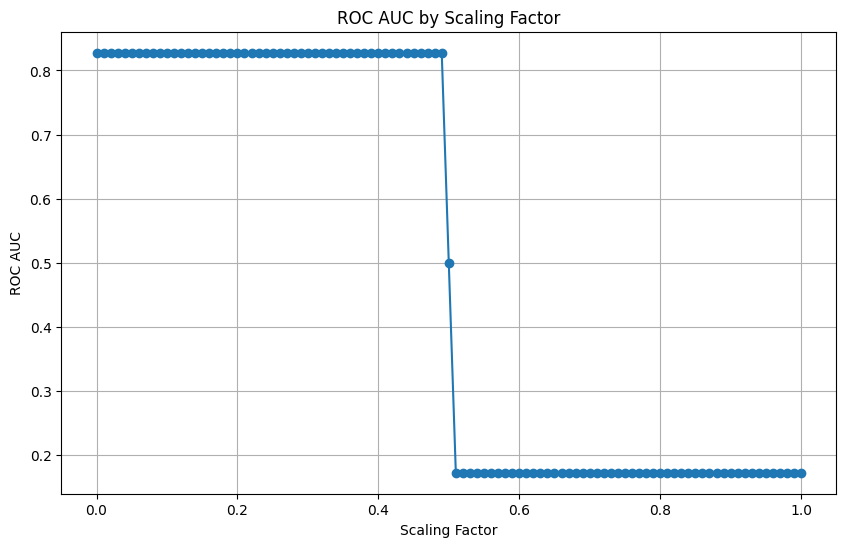

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Define function to scale probabilities
def scale_proba(probas, new_min, new_max):
    old_min = np.min(probas)
    old_max = np.max(probas)
    scaled_probas = (probas - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    return scaled_probas

roc_aucs = []
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    # Scale probabilities
    scaled_y_pred_proba = scale_proba(y_pred_proba, threshold, 1 - threshold)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test, scaled_y_pred_proba)
    roc_aucs.append(roc_auc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, roc_aucs, marker='o')
plt.title('ROC AUC by Scaling Factor')
plt.xlabel('Scaling Factor')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.show()


In [ ]:
y_pred_proba[:3]

In [ ]:
##### Find the best treshhold for the meta_learner ###

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Split the training data for validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_pca, y_train, test_size=0.2, random_state=42
)

# 2. Fit the stacking classifier
stacking_clf.fit(X_train_sub, y_train_sub)

# 3. Predict probabilities on the validation set
probs = stacking_clf.predict_proba(X_val)[:, 1]  # Assuming positive class is at index 1

# 4. Determine the optimal threshold
thresholds = np.linspace(0, 1, 101)
best_threshold = 0.5
best_score = 0

for threshold in thresholds:
    # Convert probabilities to binary predictions using the threshold
    predictions = (probs >= threshold).astype(int)
    score = roc_auc_score(y_val, predictions)
    if score > best_score:
        best_score = score
        best_threshold = threshold

print(f'Best Threshold: {best_threshold}, Best ROC AUC Score: {best_score}')

# 5. Apply the threshold for final predictions (example)
final_probs = stacking_clf.predict_proba(X_test_pca)[:, 1]
final_predictions = (final_probs >= best_threshold).astype(int)

# You may then use final_predictions for further evaluation
roc_auc = roc_auc_score(y_test, final_predictions)
print(f'ROC AUC: {roc_auc}')

In [ ]:
# Apply the specified data processing to the profile DataFrame where 'tgt' is NaN
prediction_subset = profile[profile['tgt'].isna()].copy()

# Label 'mobile_brand_name' as 'Other' if it is not in the provided list
prediction_subset['mobile_brand_name'] = prediction_subset['mobile_brand_name'].apply(lambda x: x if x in brand_names else 'Other')

# Fill missing 'education_background' with 'others'
prediction_subset['education_background'] = prediction_subset['education_background'].fillna('others')

# Apply ordinal mapping
prediction_subset['education_background'] = prediction_subset['education_background'].map(education_mapping).fillna(0).astype(int)
prediction_subset['income_level'] = prediction_subset['income_level'].map(income_mapping).fillna(0).astype(int)

In [ ]:
prediction_subset['avg_time_between_transactions'] = prediction_subset['avg_time_between_transactions'].fillna(median_value)

In [ ]:
X_kaggle = prediction_subset.drop(columns = ['tgt']) # <- drop the y column

In [ ]:
# Counting nulls in each column of X_kaggle
null_counts = X_kaggle.isna().sum()

# Printing the counts
print(null_counts)


In [ ]:
X_kaggle_encoded = encoder.transform(X_kaggle)
X_kaggle_dropped = column_dropper.transform(X_kaggle_encoded)
X_kaggle_scaled = scaler.transform(X_kaggle_dropped)
X_kaggle_test_pca = pca.transform(X_kaggle_scaled)

# Prediction for Kaggle

In [ ]:
# Make predictions using the best estimator from your grid search
pred_prob = stacking_clf.predict_proba(X_kaggle_test_pca)[:, 1]  # Assuming the positive class is at index 1

# Create a result DataFrame with user_id and predicted probabilities
result_df = pd.DataFrame({
    'user_id': prediction_subset['user_id'],
    'pred_prob': pred_prob
})

file_path = '/content/drive/My Drive/BT5153_Kaggle/predictions4.csv'

result_df.to_csv(file_path, index=False)

# Save to CSV
result_df.to_csv('predictions4.csv', index=False)

In [ ]:
print(result_df)

In [ ]:
lghuv

## LOGISTIC CLASSIFIER

## DEGREE 1

In [ ]:
# Logistic Regression Model

log = LogisticRegression(
    penalty = 'l1',
    # C = ?,          # we will let GridSearch find the best parameter
    l1_ratio = 0.5,
    solver = 'saga',
    class_weight = 'balanced',
    max_iter = 100000
    degree = 2
)

### Pipeline ###
pipe_log = Pipeline([
   #(nickname, step)
    ('encoder', encoder),
    ('scaler', scaler),
    ('log', log)
])

### Parameters to search over ###
param_grid = {
    'log__C': [0.01],
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

grid_log = GridSearchCV(pipe_log,
                        param_grid,
                        scoring=['roc_auc','precision', 'recall', 'f1', 'balanced_accuracy'], #, 'precision', 'recall', 'f1', 'balanced_accuracy'],
                        refit='roc_auc',
                        cv=cv,
                        n_jobs=-1  # Use all available cores
                       )

grid_log.fit(X_train, y_train)

### Save model ###
best_model_logistic = grid_log.best_estimator_
joblib.dump(best_model_logistic, 'best_model_log.joblib')
warnings.filterwarnings('ignore')

In [ ]:
y_pred_log = grid_log.predict(X_test)

print(classification_report(y_test, y_pred_log))

In [ ]:
grid_log.best_params_

In [ ]:
coefficient_logistic = pd.Series(
    index = best_model_logistic[:-1].get_feature_names_out(), # get feature names from the whole
    data = best_model_logistic.named_steps['log'].coef_[0]
)
coefficient_logistic.sort_values(ascending = False)

In [ ]:
from sklearn.metrics import precision_recall_curve

y_func_logistic = grid_log.decision_function(X_test)
prec, rec, thresh = precision_recall_curve(y_test, y_func_logistic, pos_label=True)
pr_df_logistic = pd.DataFrame(data={
    'precision': prec[:-1],
    'recall': rec[:-1]
    },
    index=thresh)

print(pr_df_logistic)


In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test, y_func_logistic)
plt.plot([0,1], [0,1], linestyle = 'dashed') # dummy classifier for comparison

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


log = LogisticRegression(
    penalty = 'elasticnet',
    C = 1,          # as found out from our grid search earlier
    l1_ratio = 0.5,
    solver = 'saga',
    class_weight = 'balanced',
    max_iter = 100000
)


pipe_log = Pipeline([
    ('encoder', encoder),
    ('scaler', scaler),
    ('log', log)
])


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves - Logistic Regression (Degree = 1)"
plot_learning_curve(pipe_log, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

# Linear SVC

## Degree 1

In [ ]:


# Model
svc = LinearSVC(class_weight = 'balanced', random_state = 23) # C will be searched by GridSearch

### Pipeline ###
pipe_svc = Pipeline([
   #(nickname, step)
    ('encoder', encoder),
    ('scaler', scaler),
    ('svc', svc)
])

### Parameters to search over ###
param_grid = {
    #'step__param' : [list of param values]
    'svc__C': [0.01, 0.1, 1],
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_svc = GridSearchCV(pipe_svc,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['roc_auc', 'precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'roc_auc',  # which metric to use to decide the best model
                    cv = cv,
                   )

grid_svc.fit(X_train,y_train)

### Save model ###
best_model_svc = grid_svc.best_estimator_
joblib.dump(best_model_svc, 'best_model_svc.joblib')
warnings.filterwarnings('ignore')

In [ ]:
y_pred_svc = grid_svc.predict(X_test)

print(classification_report(y_test, y_pred_svc))

In [ ]:
grid_svc.best_params_

In [ ]:
# Get the fitted OneHotEncoder from the pipeline
encoder = best_model_svc.named_steps['encoder']
onehot_encoder = encoder.named_transformers_['onehot']

# Apply transformations to the data
X_transformed = encoder.transform(X)

# Get the feature names from OneHotEncoder for the one-hot encoded columns
onehot_feature_names = onehot_encoder.get_feature_names_out(onehot_columns)

# Combine with the numerical and already encoded ordinal feature names
all_feature_names = numerical_columns + encoded_ordinal_columns + list(onehot_feature_names)

# Get the LinearSVC instance from the pipeline
svc = best_model_svc.named_steps['svc']

# Access the coefficients from the LinearSVC instance
coefficients = svc.coef_[0]

# Match the coefficients to the feature names
feature_coefficients = pd.Series(coefficients, index=all_feature_names)

# Print the feature coefficients
print(feature_coefficients.sort_values())

In [ ]:
y_func_svc = grid_svc.decision_function(X_test)

decision_function_df = pd.DataFrame({
    'decision_function' : y_func_svc,
    'actual' : y_test
})

sns.histplot(decision_function_df, x = 'decision_function', hue = 'actual', kde = True)

In [ ]:
prec, rec, thresh = precision_recall_curve(y_test, y_func_svc, pos_label = True)
pr_df = pd.DataFrame(data = {
    'precision' : prec[:-1],
    'recall' : rec[:-1]
    },
    index = thresh)

pr_df

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_func_svc)
plt.plot([0,1], [0,1], linestyle = 'dashed') # dummy classifier for comparison

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

svc = LinearSVC(class_weight = 'balanced',
                random_state = 23,
                C = 0.01)

pipe_svc = Pipeline([
    ('encoder', encoder),
    ('scaler', scaler),
    ('svc', svc)
])

title = "Learning Curves - Linear SVC (Degree = 1)"
plot_learning_curve(pipe_svc, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

## Decision Tree

In [ ]:

tree = DecisionTreeClassifier(
    class_weight = 'balanced')

### Pipeline ###
pipe_tree = Pipeline([
   #(nickname, step)
    ('encoder', encoder),
    ('scaler', scaler),
    ('tree', tree)
])

### Parameters to search over ###
param_grid = {
    #'step__param' : [list of param values]
    'tree__max_depth': [14,15,16],  #[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'tree__max_leaf_nodes':[20,30,50] #[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
}

### Validator ###
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

## GridSearch ###
grid_tree = GridSearchCV(pipe_tree,       # model to use
                    param_grid, # parameters to search over
                    scoring = ['roc_auc','precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'roc_auc',  # which metric to use to decide the best model
                    cv = cv,
                   )

grid_tree.fit(X_train,y_train)

### Save model ###
best_model_tree = grid_tree.best_estimator_
joblib.dump(best_model_tree, 'best_model_tree.joblib')
warnings.filterwarnings('ignore')

In [ ]:
y_pred_tree = grid_tree.predict(X_test)

print(classification_report(y_test, y_pred_tree))

In [ ]:
grid_tree.best_params_

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the best decision tree model from the fitted GridSearchCV object
best_tree = best_model_tree.named_steps['tree']

# Get the feature names after transformation
# Since the tree doesn't need feature scaling and it doesn't understand the scaled data,
# we only need to apply the encoder, not the scaler
encoder = best_model_tree.named_steps['encoder']
X_encoded = encoder.fit_transform(X_train)

# We can get feature names directly from the encoder if it's not a simple passthrough
# This assumes the encoder transforms or fits the data to provide feature names
if hasattr(encoder, 'get_feature_names_out'):
    feature_names = encoder.get_feature_names_out().tolist()  # Convert to list
else:
    # If encoder is 'passthrough', the original feature names are kept
    feature_names = X_train.columns.tolist()  # Convert to list

# Get the class names
class_names = [str(cls) for cls in best_tree.classes_]

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Set the figure size (optional)
plot_tree(
    decision_tree=best_tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize=5  # Adjust font size for legibility
)
plt.show()

In [ ]:
coefficient_tree = pd.Series(
    index = best_model_tree[:-1].get_feature_names_out(),
    data = best_model_tree.named_steps['tree'].feature_importances_)

coefficient_tree.sort_values(ascending = False)

In [ ]:
bfrom sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# First, get the predicted probabilities for the positive class
y_pred_prob_tree = grid_tree.predict_proba(X_test)[:, 1]

# Calculate the AUC ROC score
auc_roc_tree = roc_auc_score(y_test, y_pred_prob_tree)
print(f'AUC ROC for Decision Tree Model: {auc_roc_tree}')

# Now, plot the ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob_tree)
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill Classifier') # This is the line for a model with no skill
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


## Decision Tree with Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

tree = DecisionTreeClassifier(
    class_weight = 'balanced')

### Pipeline ###
pipe_tree = Pipeline([
   #(nickname, step)
    ('encoder', encoder),
    ('scaler', scaler),
    ('tree', tree)
])

# Define the parameter distribution rather than a parameter grid
param_dist = {
    'tree__max_depth': randint(1, 20),  # Uniform distribution over [1, 20]
    'tree__min_samples_split': randint(2, 20),
    'tree__min_samples_leaf': randint(2, 20),
    'tree__max_features': [None, 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search_tree = RandomizedSearchCV(pipe_tree,
                                        param_distributions=param_dist,
                                        n_iter=100,  # Number of parameter settings that are sampled
                                        scoring='roc_auc',
                                        cv=cv,
                                        random_state=42,
                                        )

# Fit RandomizedSearchCV
random_search_tree.fit(X_train, y_train)

# Extract the best estimator
best_model_tree_random = random_search_tree.best_estimator_
joblib.dump(best_model_tree_random, 'best_model_tree_random.joblib')


In [ ]:
y_pred_random_search_tree = random_search_tree.predict(X_test)

print(classification_report(y_test, y_pred_random_search_tree))

In [ ]:
random_search_tree.best_params_

In [ ]:
coefficient_tree = pd.Series(
    index = best_model_tree_random[:-1].get_feature_names_out(),
    data = best_model_tree_random.named_steps['tree'].feature_importances_)

coefficient_tree.sort_values(ascending = False)

In [ ]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# First, get the predicted probabilities for the positive class
y_pred_prob_tree = random_search_tree.predict_proba(X_test)[:, 1]

# Calculate the AUC ROC score
auc_roc_tree = roc_auc_score(y_test, y_pred_prob_tree)
print(f'AUC ROC for Decision Tree Model: {auc_roc_tree}')

# Now, plot the ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob_tree)
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill Classifier') # This is the line for a model with no skill
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    max_features=11,# Approx the number of features with more than 1% importance
    random_state = 2023,  # random state for reproducibility
    class_weight = 'balanced',
    min_samples_split=4,
     min_samples_leaf=2,

)

pipe_forest = Pipeline([
   #(nickname, step)
    ('encoder', encoder),
    ('scaler', scaler),
    ('rf', rf)
])

### Parameters to search over ###
#param_grid_forest = {
    #'step__param' : [list of param values]
#    'rf__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
 #   'rf__max_leaf_nodes': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
#}

param_dist = {
    'rf__max_depth': randint(1, 10),  # Uniform distribution over [1, 20]
    'rf__max_features': ['sqrt', 'log2'],
    'rf__n_estimators': randint(2, 50),  # Use ':' instead of '=' for assignment
}


### Validator ###
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 23)

## GridSearch ###
grid_forest = RandomizedSearchCV(pipe_forest,       # model to use
                    param_distributions=param_dist, # parameters to search over
                    scoring = ['roc_auc','precision', 'recall', 'f1', 'balanced_accuracy'], # metrics to compute
                    refit = 'roc_auc',  # which metric to use to decide the best model
                    cv = cv,
                   )


grid_forest.fit(X_train, y_train)

y_pred_forest = grid_forest.predict(X_test)

print(classification_report(y_test, y_pred_forest))

In [ ]:
grid_forest.best_params_

In [ ]:
### Save model ###
best_forest = grid_forest.best_estimator_
joblib.dump(best_forest, 'best_model_forest.joblib')
warnings.filterwarnings('ignore')

In [ ]:
# Assuming 'grid_forest' is your trained RandomizedSearchCV with the pipeline
best_forest = grid_forest.best_estimator_

# Extract the RandomForestClassifier from the pipeline
random_forest_model = best_forest.named_steps['rf']

# Assuming 'encoder' is your ColumnTransformer, get the feature names after transformation
# Note: This step should be done after fitting your pipeline/model as the feature names can be extracted correctly only after fitting
feature_names = best_forest.named_steps['encoder'].get_feature_names_out()

# Extract feature importances from the random forest model
feature_importances = random_forest_model.feature_importances_

# Create a Series for the feature importances
feature_importance_series = pd.Series(feature_importances, index=feature_names)
feature_importance_series = feature_importance_series.sort_values(ascending=False)

print(feature_importance_series)

# Plotting
plt.figure(figsize=(10, 6))
feature_importance_series.plot(kind='bar')
plt.title('Feature Importances in RandomForest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Get the predicted probabilities for the positive class
y_pred_prob_forest = grid_forest.predict_proba(X_test)[:, 1]

# Calculate the AUC ROC
auc_roc_forest = roc_auc_score(y_test, y_pred_prob_forest)
print(f'AUC ROC for Random Forest Model: {auc_roc_forest}')


In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Plot the ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob_forest)
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill Classifier') # This is the line for a model with no skill
plt.title('ROC Curve for Random Forest Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


# RETRAIN WITH ALL THE DATA FOR KAGGLE SUBMISSION

## Random Search Decision Tree

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

tree = DecisionTreeClassifier(
    class_weight = 'balanced')

### Pipeline ###
pipe_tree = Pipeline([
   #(nickname, step)
    ('encoder', encoder),
    ('scaler', scaler),
    ('tree', tree)
])

# Define the parameter distribution rather than a parameter grid
param_dist = {
    'tree__max_depth': randint(1, 20),  # Uniform distribution over [1, 20]
    'tree__min_samples_split': randint(2, 20),
    'tree__min_samples_leaf': randint(2, 20),
    'tree__max_features': [None, 'sqrt', 'log2']
}

# Initialize RandomizedSearchCV
random_search_tree = RandomizedSearchCV(pipe_tree,
                                        param_distributions=param_dist,
                                        n_iter=100,  # Number of parameter settings that are sampled
                                        scoring='roc_auc',
                                        cv=cv,
                                        random_state=42,
                                        )

# Fit RandomizedSearchCV
random_search_tree.fit(X, y)

# Extract the best estimator
best_model_tree_random = random_search_tree.best_estimator_
joblib.dump(best_model_tree_random, 'best_model_tree_random.joblib')

In [ ]:
random_search_tree.best_params_

In [ ]:
coefficient_tree = pd.Series(
    index = best_model_tree_random[:-1].get_feature_names_out(),
    data = best_model_tree_random.named_steps['tree'].feature_importances_)

coefficient_tree.sort_values(ascending = False)

# DATA PREPARATION FOR KAGGLE SUBMISSION

In [ ]:
# Apply the specified data processing to the profile DataFrame where 'tgt' is NaN
prediction_subset = profile[profile['tgt'].isna()].copy()

# Label 'mobile_brand_name' as 'Other' if it is not in the provided list
prediction_subset['mobile_brand_name'] = prediction_subset['mobile_brand_name'].apply(lambda x: x if x in brand_names else 'Other')

# Fill missing 'education_background' with 'others'
prediction_subset['education_background'] = prediction_subset['education_background'].fillna('others')

# Apply ordinal mapping
prediction_subset['education_background'] = prediction_subset['education_background'].map(education_mapping).fillna(0).astype(int)
prediction_subset['income_level'] = prediction_subset['income_level'].map(income_mapping).fillna(0).astype(int)

In [ ]:
prediction_subset['avg_time_between_transactions'] = prediction_subset['avg_time_between_transactions'].fillna(median_value)

In [ ]:
X_kaggle = prediction_subset.drop(columns = ['tgt']) # <- drop the y column

In [ ]:
# Counting nulls in each column of X_kaggle
null_counts = X_kaggle.isna().sum()

# Printing the counts
print(null_counts)


# Prediction for Kaggle

In [ ]:
# Make predictions using the best estimator from your grid search
pred_prob = random_search_tree.predict_proba(X_kaggle)[:, 1]  # Assuming the positive class is at index 1

# Create a result DataFrame with user_id and predicted probabilities
result_df = pd.DataFrame({
    'user_id': prediction_subset['user_id'],
    'pred_prob': pred_prob
})

file_path = '/content/drive/My Drive/BT5153_Kaggle/predictions.csv'

result_df.to_csv(file_path, index=False)

# Save to CSV
result_df.to_csv('predictions.csv', index=False)

In [ ]:
print(result_df)

##Manual Stacking

In [ ]:
import numpy as np

# Step 1: Generate new features by predicting with the pre-trained models
# Note: Adjust the .predict_proba() method if your task or models require a different method of prediction.

# For training set (to train the meta-model)
X_train_new = np.column_stack([
    model.predict(X_train)[:, 1] for model in (grid_log.best_estimator_, grid_svc.best_estimator_, grid_tree.best_estimator_)
])

# For test set (to evaluate the stacked model)
X_test_new = np.column_stack([
    model.predict_proba(X_test)[:, 1] for model in (grid_log.best_estimator_, grid_svc.best_estimator_, grid_tree.best_estimator_)
])

# Step 2: Train the meta-model on the new features created from the training set predictions
# Choosing Logistic Regression as the meta-model for this example
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(X_train_new, y_train)

# Step 3: Use the trained meta-model to make final predictions on the test set
y_pred_meta = meta_model.predict(X_test_new)
y_pred_prob_meta = meta_model.predict_proba(X_test_new)[:, 1]  # For AUC

# Evaluate the stacked model
from sklearn.metrics import accuracy_score, roc_auc_score

print(f"Accuracy: {accuracy_score(y_test, y_pred_meta)}")
print(f"AUC ROC: {roc_auc_score(y_test, y_pred_prob_meta)}")


### Good Stacking --> For Kaggle

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Extract the best estimator from each GridSearchCV result
best_log = grid_log.best_estimator_
best_svc = grid_svc.best_estimator_
best_tree = grid_tree.best_estimator_

# Define the base models
base_models = [
    ('logistic', best_log),
    ('svc', best_svc),
    ('tree', best_tree)
]

# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacked model on the training data
stacked_model.fit(X_train, y_train)

# Now you can make predictions and evaluate the stacked model as usual
y_pred_stack = stacked_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, roc_auc_score

print(f"Accuracy: {accuracy_score(y_test, y_pred_stack)}")
y_pred_prob_stack = stacked_model.predict_proba(X_test)[:, 1]
print(f"AUC ROC: {roc_auc_score(y_test, y_pred_prob_stack)}")


In [ ]:
df.columns

In [ ]:
for column in ['mobile_brand_name','gender_name','marital_status','occupation','marekting_cluster']:
    print(df[column].unique())

In [ ]:
for column in ['education_background','income_level']:
    print(column)
    print(df[column].unique())

In [ ]:
null_counts = X_train.isnull().sum()
print(null_counts)